<a href="https://colab.research.google.com/github/mbc2009/Lmp_ML/blob/main/Trials/Trial_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Enviornment Initialization

In [1]:
%%capture
%%bash

# remove unnecessary
rm -rf *

# update pip
python -m pip install --upgrade pip

# install package
pip install opencv-python pillow
pip install segmentation_models_pytorch
pip install -q kaggle
pip install dropbox
pip install scikit-image
pip install pandas openpyxl

In [2]:
# basic import
import  os, sys, time, math, random, math, psutil, h5py, re, pickle
from    datetime                import datetime
from    concurrent.futures      import ThreadPoolExecutor
from    typing                  import  List, Tuple
from    dropbox                 import  Dropbox
from    tqdm                    import  tqdm
from    mpl_toolkits.mplot3d    import  Axes3D
from    matplotlib              import  pyplot      as plt
import  numpy                                       as np
import  pandas                                      as pd
import  zipfile
import  warnings
import  shutil
import  joblib

from    sklearn.preprocessing   import MinMaxScaler
from    sklearn.metrics         import r2_score, mean_absolute_error,mean_squared_error,explained_variance_score,mean_squared_log_error
from    skimage                 import  io
from    sklearn.model_selection import KFold

import  scipy
from    scipy                   import  interpolate,stats
from    scipy.interpolate       import  RegularGridInterpolator
from    scipy.ndimage           import  generic_filter, rotate

import  torch
from    torch                   import  nn
from    torch.nn                import  functional  as F
import  torch.optim                                 as optim
import  torchvision.transforms.functional           as TF
from    torch.utils.data        import  Dataset, DataLoader, TensorDataset, random_split, Subset
from    torchvision             import  transforms, models
from    torchvision.transforms  import  *
from    PIL                     import  Image
import  kagglehub

In [3]:
# check hardware
print(f"CPU core #:\t{os.cpu_count()}")
print(f"CPU threads #:\t{psutil.cpu_count(logical=True)}")
print(f"Total memory:\t\t{psutil.virtual_memory().total / (1024**3):.2f} GB")
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"available GPU #:\t{gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i+1}:\t\t{gpu_name}")
else:
    print("No available GPU")

CPU core #:	12
CPU threads #:	12
Total memory:		83.48 GB
available GPU #:	1
GPU 1:		NVIDIA A100-SXM4-40GB


#1.Model Designing

In [4]:
class ViT3D(nn.Module):
    def __init__(self, input_dim=32 * 32 * 32, d_model=128, nhead=4, num_layers=2):
        super(ViT3D, self).__init__()
        self.fc1 = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc2 = nn.Linear(d_model + 1, 64)  # 额外加入 temp_i
        self.output_dim = len(conf.DB_items) - 1
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(0)  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)
        x = x.squeeze(0)  # 恢复 batch 维度
        temp_i = tensor_i.unsqueeze(1)
        x = torch.cat((x, temp_i), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Swin3D(nn.Module):
    def __init__(self, input_dim=32 * 32 * 32, d_model=128, nhead=4, num_layers=2):
        super(Swin3D, self).__init__()
        self.fc1 = nn.Linear(input_dim, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc2 = nn.Linear(d_model + 1, 64)  # 额外加入 temp_i
        self.output_dim = len(conf.DB_items) - 1
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(0)  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)
        x = x.squeeze(0)  # 恢复 batch 维度
        temp_i = tensor_i.unsqueeze(1)
        x = torch.cat((x, temp_i), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class Pure3DCNN(nn.Module):
    def __init__(self):
        super(Pure3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半

        # 由于去掉 Transformer，fc1 之后直接进入 fc2
        self.fc1 = nn.Linear(32 * 32 * 32 * 32, 128)  # CNN 提取的特征
        self.fc2 = nn.Linear(128 + 1, 64)  # 额外加入 temp_i（1 维）
        self.output_dim = len(conf.DB_items) - 1  # 计算输出维度
        self.fc3 = nn.Linear(64, self.output_dim)  # 最终输出层

    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128³ -> 64³
        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³
        x = x.view(-1, 32 * 32 * 32 * 32)  # 展平

        x = F.relu(self.fc1(x))  # fc1 out: CNN 特征提取

        temp_i  = tensor_i.unsqueeze(1)  # 只取 temp_i，形状变为 (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)  # 拼接 temp_i

        x = F.relu(self.fc2(x))  # fc2 out: relu
        x = self.fc3(x)  # fc3 out: 输出最终结果
        return x

In [6]:
class Improved3DCNN(nn.Module):
    def __init__(self):
        """
        初始化 Improved3DCNN 模型，结合改进的 CNN 结构和增强的 Transformer 建模能力。
        温度信息在 NN 部分加入，Transformer 只处理形貌特征。

        模型结构：
        1. CNN 部分：通过三层 3D 卷积提取局部特征，增加深度并引入残差连接。
        2. 多尺度子区域提取：从不同分辨率（16×16×16 和 8×8×8）提取特征，提供更细粒度的局部信息。
        3. Transformer 部分：使用窗口注意力机制处理多尺度特征，增强全局建模能力。
        4. NN 部分：将多尺度特征与温度信息融合后预测目标变量（如水分子扩散系数和通量）。

        参数：
        - conf.DB_items: 包含目标变量列表，长度为 10（1 个温度 + 9 个目标变量）。
        """
        super(Improved3DCNN, self).__init__()

        # CNN 部分：三层 3D 卷积，用于提取局部特征
        # 输入：(batch_size, 1, 128, 128, 128)
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)
        # conv1 输出：(batch_size, 16, 128, 128, 128)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        # conv2 输出：(batch_size, 32, 64, 64, 64)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        # conv3 输出：(batch_size, 64, 32, 32, 32)
        self.pool = nn.MaxPool3d(2, 2)  # 池化层，空间维度减半

        # 残差连接：调整通道数以匹配 conv2 和 conv3 的输出
        self.conv_res1 = nn.Conv3d(16, 32, kernel_size=1, stride=1)
        # conv_res1 输出：(batch_size, 32, 64, 64, 64)，匹配 conv2
        self.conv_res2 = nn.Conv3d(32, 64, kernel_size=1, stride=1)
        # conv_res2 输出：(batch_size, 64, 32, 32, 32)，匹配 conv3

        # 多尺度子区域提取
        # 从 32×32×32 提取 16×16×16 子区域
        self.subregion_fc1 = nn.Conv3d(32, 31, kernel_size=4, stride=2, padding=1)
        # subregion_fc1 输出：(batch_size, 31, 16, 16, 16)，stride=2 使 32/2=16
        # 从 32×32×32 提取 8×8×8 子区域
        self.subregion_fc2 = nn.Conv3d(64, 31, kernel_size=4, stride=4)
        # subregion_fc2 输出：(batch_size, 31, 8, 8, 8)，stride=4 使 32/4=8

        # 位置编码：为 Transformer 输入添加位置信息
        # 16×16×16 子区域的序列长度为 4096，特征维度为 31（移除温度后）
        self.pos_encoder1 = nn.Parameter(torch.zeros(16 * 16 * 16, 1, 31))  # (4096, 1, 31)
        # 8×8×8 子区域的序列长度为 512，特征维度为 31
        self.pos_encoder2 = nn.Parameter(torch.zeros(8 * 8 * 8, 1, 31))     # (512, 1, 31)

        # Transformer 模型：处理多尺度特征，增强全局建模能力
        # d_model=31（特征维度），nhead=1（31 是质数，nhead 必须是 d_model 的因子），dim_feedforward=128
        self.transformer1 = TransformerEncoderLayer(d_model=31, nhead=1, dim_feedforward=128, dropout=0.1, window_size=64)
        self.transformer2 = TransformerEncoderLayer(d_model=31, nhead=1, dim_feedforward=128, dropout=0.1, window_size=32)

        # Transformer 输出降维
        self.fc_transformer1 = nn.Linear((16 * 16 * 16) * 31, 256)  # 从 4096×31 降维到 256
        self.fc_transformer2 = nn.Linear((8 * 8 * 8) * 31, 128)     # 从 512×31 降维到 128

        # 最终全连接层：融合多尺度特征和温度信息并预测目标变量
        self.fc2 = nn.Linear(256 + 128 + 1, 64)  # 256 (尺度1) + 128 (尺度2) + 1 (温度)
        self.output_dim = len(conf.DB_items) - 1  # 输出维度：9（目标变量数量）
        self.fc3 = nn.Linear(64, self.output_dim)

    def forward(self, x, tensor_i):
        """
        前向传播函数，处理输入网格和温度，输出预测结果。
        温度信息在 NN 部分加入，Transformer 只处理形貌特征。

        参数：
        - x: 输入网格，形状 (batch_size, 1, 128, 128, 128)
        - tensor_i: 温度标量，形状 (batch_size,)

        返回：
        - 输出：预测结果，形状 (batch_size, 9)，对应 9 个目标变量
        """
        # 确保 tensor_i 是 (batch_size,) 的一维张量
        if tensor_i.dim() > 1:
            tensor_i = tensor_i.squeeze()
            if tensor_i.dim() > 1:
                tensor_i = tensor_i[:, 0]
        assert tensor_i.dim() == 1, f"Expected tensor_i to be 1D, got shape {tensor_i.shape}"

        # CNN 特征提取
        # 输入：(batch_size, 1, 128, 128, 128)
        x1 = F.relu(self.conv1(x.float()))  # (batch_size, 16, 128, 128, 128)
        x1 = self.pool(x1)  # (batch_size, 16, 64, 64, 64)

        x2 = F.relu(self.conv2(x1))  # (batch_size, 32, 64, 64, 64)
        x1_res = self.conv_res1(x1)  # (batch_size, 32, 64, 64, 64)，调整通道以匹配 x2
        x2 = x2 + x1_res  # 残差连接，保留信息

        x2 = self.pool(x2)  # (batch_size, 32, 32, 32, 32)
        x3 = F.relu(self.conv3(x2))  # (batch_size, 64, 32, 32, 32)
        x2_res = self.conv_res2(x2)  # (batch_size, 64, 32, 32, 32)，调整通道以匹配 x3
        x3 = x3 + x2_res  # 残差连接

        # 多尺度子区域提取
        x1 = self.subregion_fc1(x2)  # (batch_size, 31, 16, 16, 16)，提取 16×16×16 子区域
        x2 = self.subregion_fc2(x3)  # (batch_size, 31, 8, 8, 8)，提取 8×8×8 子区域

        # 尺度 1：16×16×16 子区域（不拼接温度）
        x1 = x1.view(-1, 31, 16 * 16 * 16)  # (batch_size, 31, 4096)
        x1 = x1.permute(2, 0, 1)  # (4096, batch_size, 31)，调整为 (seq_len, batch_size, d_model)
        x1 = x1 + self.pos_encoder1  # (4096, batch_size, 31)，添加位置编码
        x1 = self.transformer1(x1)  # (4096, batch_size, 31)，应用 Transformer
        x1 = x1.permute(1, 0, 2)  # (batch_size, 4096, 31)
        x1 = x1.reshape(-1, (16 * 16 * 16) * 31)  # (batch_size, 4096×31)
        x1 = F.relu(self.fc_transformer1(x1))  # (batch_size, 256)，降维

        # 尺度 2：8×8×8 子区域（不拼接温度）
        x2 = x2.view(-1, 31, 8 * 8 * 8)  # (batch_size, 31, 512)
        x2 = x2.permute(2, 0, 1)  # (512, batch_size, 31)
        x2 = x2 + self.pos_encoder2  # (512, batch_size, 31)，添加位置编码
        x2 = self.transformer2(x2)  # (512, batch_size, 31)，应用 Transformer
        x2 = x2.permute(1, 0, 2)  # (batch_size, 512, 31)
        x2 = x2.reshape(-1, (8 * 8 * 8) * 31)  # (batch_size, 512×31)
        x2 = F.relu(self.fc_transformer2(x2))  # (batch_size, 128)，降维

        # 融合多尺度特征并加入温度信息
        x = torch.cat((x1, x2), dim=1)  # (batch_size, 256 + 128)
        temp_i = tensor_i.view(-1, 1)  # (batch_size, 1)，调整温度维度
        x = torch.cat((x, temp_i), dim=1)  # (batch_size, 256 + 128 + 1)，在 NN 部分加入温度
        x = F.relu(self.fc2(x))  # (batch_size, 64)
        x = self.fc3(x)  # (batch_size, 9)，输出预测结果
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=31, nhead=1, dim_feedforward=128, dropout=0.1, window_size=64):
        """
        Transformer 编码器层，使用窗口注意力机制降低计算复杂度。

        参数：
        - d_model: 输入和输出的特征维度，调整为 31（移除温度后）。
        - nhead: 多头注意力机制的头数，调整为 1（31 的因子）。
        - dim_feedforward: 前馈网络的隐藏层维度，默认为 128。
        - dropout: Dropout 比例，默认为 0.1。
        - window_size: 窗口大小，限制注意力范围，默认为 64。
        """
        super(TransformerEncoderLayer, self).__init__()
        self.window_size = window_size
        # 单个 Transformer 编码层
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        # 堆叠 4 层 Transformer 编码层，增强建模能力
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=4)

    def forward(self, x):
        """
        前向传播函数，应用窗口注意力机制。

        参数：
        - x: 输入张量，形状 (seq_len, batch_size, d_model)

        返回：
        - 输出张量，形状 (seq_len, batch_size, d_model)
        """
        seq_len, batch_size, d_model = x.shape
        # 计算窗口数量，按 window_size 分割序列
        num_windows = (seq_len + self.window_size - 1) // self.window_size
        # 按窗口处理，降低计算复杂度
        for i in range(num_windows):
            start = i * self.window_size
            end = min((i + 1) * self.window_size, seq_len)
            x[start:end] = self.transformer(x[start:end])  # 仅在窗口内计算注意力
        return x

In [7]:
'''
# lagacy-2: Trans/CNN with subregions

class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)
        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半

        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN 提取的特征
        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer 处理特征
        self.fc2          = nn.Linear(128 + 1, 64)          # 只加入 temp_i（1 维）
        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension
        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items


    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128³ -> 64³
        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³
        x = x.view(-1, 32 * 32 * 32 * 32)     # 展平

        x = F.relu(self.fc1(x))             # fc1 out: CNN 特征提取
        x = x.unsqueeze(0)                  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)             # 通过 Transformer 处理
        x = x.squeeze(0)                    # 恢复 batch 维度

        temp_i  = tensor_i.unsqueeze(1)            # 只取 temp_i，形状变为 (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)    # 拼接 temp_i

        x = F.relu(self.fc2(x))             # fc2 out: relu
        x = self.fc3(x)                     # fc3 out: 输出最终结果
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, nhead=4, dim_feedforward=256, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer   = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    def forward(self, x):
        return self.transformer(x)
'''

'\n# lagacy-2: Trans/CNN with subregions\n\nclass Improved3DCNN(nn.Module):\n    def __init__(self):\n        super(Improved3DCNN, self).__init__()\n        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)\n        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)\n        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半\n\n        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN 提取的特征\n        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer 处理特征\n        self.fc2          = nn.Linear(128 + 1, 64)          # 只加入 temp_i（1 维）\n        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension\n        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items\n\n\n    def forward(self, x, tensor_i):\n        x = self.pool(F.relu(self.conv1(x.float())))  # 128³ -> 64³\n        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³\n   

In [8]:
'''
# lagacy-1: Trans/CNN


class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)
        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半

        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN 提取的特征
        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer 处理特征
        self.fc2          = nn.Linear(128 + 1, 64)          # 只加入 temp_i（1 维）
        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension
        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items


    def forward(self, x, tensor_i):
        x = self.pool(F.relu(self.conv1(x.float())))  # 128³ -> 64³
        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³
        x = x.view(-1, 32 * 32 * 32 * 32)     # 展平

        x = F.relu(self.fc1(x))             # fc1 out: CNN 特征提取
        x = x.unsqueeze(0)                  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)             # 通过 Transformer 处理
        x = x.squeeze(0)                    # 恢复 batch 维度

        temp_i  = tensor_i.unsqueeze(1)            # 只取 temp_i，形状变为 (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)    # 拼接 temp_i

        x = F.relu(self.fc2(x))             # fc2 out: relu
        x = self.fc3(x)                     # fc3 out: 输出最终结果
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, nhead=4, dim_feedforward=256, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer   = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    def forward(self, x):
        return self.transformer(x)
'''

'\n# lagacy-1: Trans/CNN\n\n\nclass Improved3DCNN(nn.Module):\n    def __init__(self):\n        super(Improved3DCNN, self).__init__()\n        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)\n        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)\n        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半\n\n        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN 提取的特征\n        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer 处理特征\n        self.fc2          = nn.Linear(128 + 1, 64)          # 只加入 temp_i（1 维）\n        self.output_dim   = len(conf.DB_items) - 1          # Calculate output dimension\n        self.fc3          = nn.Linear(64, self.output_dim)  # Output dimension based on conf.DB_items\n\n\n    def forward(self, x, tensor_i):\n        x = self.pool(F.relu(self.conv1(x.float())))  # 128³ -> 64³\n        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³\n        x = x.vie

# 2.Configuration

In [9]:
class Confuration():
  # define paths to directory
  home_dir                = os.path.expanduser("~")
  working_dir             = os.path.join(os.getcwd(),'Lmp_ML')
  DataBase_dir            = os.path.join(working_dir,'DataBase')
  DB_version              = ''
  DB_3D_Grids_density     = 128
  DB_3D_Grids_path        = os.path.join(DataBase_dir, f'{DB_version}', f'3D_Grids_{DB_3D_Grids_density}.h5') # TODO: choose database version, here ver=4
  DB_Excel_path           = os.path.join(working_dir,  f'LmpGP.xlsx')                                         # TODO: choose database version, here ver=4

  # dataset
  DB_items                = ['temp\n(k)',
                             'len\n(A)',
                             'density\n(g/cm^3)',
                             'pore_radius\n(A)',
                             'porosity\n(unitless)',
                             #'bond_density\n(unitless)',
                             'specific_surface_area\n(m^2/g)',
                             'tortuosity\n(unitless)(smoothed_by_Surface area)',
                             #'tortuosity\n(unitless)',
                             'flux\n(L/m^2/h)(smoothed_by_Pore radius)(smoothed_by_Tortuosity)(smoothed_by_Porosity)',
                             #'flux\n(L/m^2/h)',,
                             'Diffusivity_TA_filtrates\n_in_membrane\n(m^2/s)(averaged)(smoothed_by_Surface area)(smoothed_by_Pore radius)',
                             #'Diffusivity_TA_filtrates\n_in_membrane\n(m^2/s)(averaged)',
                             'thermal_conductivity\n(W/(m·K))'
                             ]

  # training hyperpatameters
  device              = None
  model               = None
  criterion           = nn.MSELoss()
  optimizer           = optim.Adam
  train_mode          = 'k-fold' #'simple'


  # debug
  dev_mode                = False

conf = Confuration()
conf.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conf.model  = Improved3DCNN().to(conf.device) # TODO: select model

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
# import code from git hub
!git clone https://github.com/mbc2009/Lmp_ML

Cloning into 'Lmp_ML'...
remote: Enumerating objects: 789, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 789 (delta 73), reused 38 (delta 38), pack-reused 694 (from 3)
Receiving objects: 100% (789/789), 166.21 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [11]:
# make directory
os.makedirs(conf.DataBase_dir, exist_ok=True)

In [12]:
# download
original_path = kagglehub.dataset_download("mbc2009/heat-and-mass-transfer",force_download=True)
# copy
shutil.copytree(original_path, conf.DataBase_dir, dirs_exist_ok=True)
# Remove
#!rm -rf {original_path}

'/content/Lmp_ML/DataBase'

# 3.Preparing Database

## 3.1. Prepare Excel Data Base

In [13]:
def check_hdf5_content(file_path:str,PrintStrcut=False)->int:
  '''
  check the content (name, quantity) of hdf5 file
  input:
    file_path: the path of hdf5 file
    PrintStrcut: print the structure of hdf5 file
  return:
    the name and quantity of variables in hdf5 file
  '''
  # 初始化数据集计数器
  dataset_count = 0

  # 定义一个内部函数用于遍历 HDF5 文件内部
  def count_datasets(name, obj):
        nonlocal dataset_count
        if isinstance(obj, h5py.Dataset):  # 判断是否为数据集
            dataset_count += 1
        elif isinstance(obj, h5py.Group):  # 判断是否为组
            pass  # 如果是组，不计数

  with h5py.File(file_path, "r") as h5f:

        # 遍历文件内容以计数
        h5f.visititems(count_datasets)

        # 打印所有内变量名字
        if PrintStrcut:
          print(f"文件结构:")
          h5f.visit(print)

  print(f'文件数: {dataset_count}')

  return dataset_count # 文件数


In [14]:
# convert Excel data into pandas data frame
df = pd.read_excel(conf.DB_Excel_path, engine="openpyxl")

In [15]:
if conf.dev_mode:
  # 打印形状
  print(df.shape)

  # 读取列名
  print(df.columns)

In [16]:
if conf.dev_mode:
  # 筛选列名对应列
  df = df.loc[:, ['len\n(A)', 'sigma\n(A)', 'temp\n(k)', 'flux\n(L/m^2/h)', 'density\n(g/cm^3)']]

In [17]:
def fetch_from_pandas(len_i: int, sigma_i: int, temp_i: int, items: List[str], df: pd.DataFrame) -> torch.Tensor:
    """
    根据 len_i, sigma_i, temp_i 在 pandas DataFrame 中查找指定 items，并返回一个 PyTorch Tensor。

    Args:
        len_i (int):        目标 len 值
        sigma_i (int):      目标 sigma 值
        temp_i (int):       目标 temp 值
        items (List[str]):  需要提取的列名列表
        df (pd.DataFrame):  数据源 Pandas DataFrame

    Returns:
        Optional[torch.Tensor]: 若找到数据，则返回一个 Float32 类型的 PyTorch Tensor，否则返回 None。
    """
    try:
        # 筛选符合条件的行，并提取多个列
        item_values = df.loc[
            (df["len\n(A)"] == len_i) &
            (df["sigma\n(A)"] == sigma_i) &
            (df["temp\n(k)"] == temp_i),
            items
        ]

        # 确保只有一行数据，转换为 Tensor
        if not item_values.empty:
            tensor_values = torch.tensor(item_values.values.flatten(), dtype=torch.float32)
            return tensor_values
        else:
            return None  # 没有匹配数据时返回 None

    except KeyError as e:
        print(f"列名错误: {e}")
        return None

    except ValueError as e:
        print(f"数据转换错误: {e}")
        return None

In [18]:
if conf.dev_mode:
  # 使用示例
  items = fetch_from_pandas(len_i= 2, sigma_i=8, temp_i=373, items=['density\n(g/cm^3)'], df=df)
  print(items[0].item())

## 3.2.Check grid data base

In [19]:
if conf.dev_mode:
  # 查看hdf5文件内容
  num_grids = check_hdf5_content(conf.DB_3D_Grids_path,PrintStrcut=False)

In [20]:
if conf.dev_mode:
  # 查看单个数据点
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]
  print(f'矩阵形状:   {GA.shape}')
  print(f'矩阵最大值: {np.max(GA)}')
  print(f'矩阵最小值: {np.min(GA)}')
  print(f"矩阵 GA 中 {np.max(GA)} 的数量：{np.count_nonzero(GA == np.max(GA)) }")

In [21]:
# 可视化函数
def plot_3D_Grid(matrix_3d):
    """
    绘制三维点阵的三视图（正视图、侧视图、俯视图）。

    Args:
        matrix_3d (numpy.ndarray): 三维点阵数据。

    Returns:
        None
    """
    # 创建图形和坐标轴
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 俯视图 (X-Y 平面)
    axes[0].imshow(np.sum(matrix_3d, axis=0), cmap='viridis')  # 沿 Z 轴求和
    axes[0].set_title('Top View (X-Y)')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    # 正视图 (Z-X 平面)
    axes[1].imshow(np.sum(matrix_3d, axis=1), cmap='viridis')  # 沿 Y 轴求和
    axes[1].set_title('Front View (Z-X)')
    axes[1].set_xlabel('Z')
    axes[1].set_ylabel('X')

    # 侧视图 (Z-Y 平面)
    axes[2].imshow(np.sum(matrix_3d, axis=2), cmap='viridis')  # 沿 X 轴求和
    axes[2].set_title('Side View (Z-Y)')
    axes[2].set_xlabel('Z')
    axes[2].set_ylabel('Y')

    # 显示图形
    plt.show()

In [22]:
if conf.dev_mode:
  plot_3D_Grid(GA)  # 将 GA 替换为你的三维点阵数据

## 3.3.Home-brewing dataset

In [23]:
class myDataBase(Dataset):
    def __init__(self,
                 hdf5_3D_Grids_file_path:str,
                 excel_Performance_and_Properties_file_path:str):
        '''
        name:  'len_{i}_sigma_{j}_temp_{k}'
        label: [len_i, sigma_i, temp_i], type: pytorch tensor
        structure: 3D grid, type: pytorch tensor
        '''
        ## GRID
        # 3D grids (h5py file)
        self.grids_hdf5     = h5py.File(hdf5_3D_Grids_file_path, 'r')
        # Sorted name list of all GA structures (h5py file)
        self.data_NameList  = self.sort_NameList((self.grids_hdf5.keys()))

        ## EXCEL
        # Performance & Properties (Excel => PD)
        self.PnP_pd = pd.read_excel(excel_Performance_and_Properties_file_path, engine="openpyxl")
        self.PnP_pd = self.PnP_pd

        # Normalize PD file
        self.scaler           = MinMaxScaler()
        self.PnP_pd_selected  = self.PnP_pd[conf.DB_items].copy()                # Select desired columns from the original DataFrame
        self.PnP_pd_scaled    = self.scaler.fit_transform(self.PnP_pd_selected)  # Scale the selected data
        self.PnP_pd_scaled    = pd.DataFrame(self.PnP_pd_scaled,                 # Convert to DataFrame
                                          columns=self.PnP_pd_selected.columns)


        joblib.dump(self.scaler, "scaler.pkl")  # 保存 scaler（用于推理时 inverse_transform 反归一化）
        print('Scaler Saved')

    def __len__(self):
        return len(self.data_NameList)

    def __getitem__(self, index):
        ## 1. Index ##
        # 解析: index -> str
        name_i      = self.data_NameList[index]

        # 转换: str -> list [len_i, sigma_i, temp_i] -> tensor
        label_i     = self.extract_label_from_key(name_i)

        ## 2. GRIDS ##
        # 提取 (hdf5 => np.ndarray)
        grid_i      = self.grids_hdf5[name_i][:]
        # 转换: Grids (np.ndarray -> PyTorch tensor)
        grid_i      = torch.from_numpy(grid_i)

        ## 3. EXCEL ##
        # find row index
        pd_idx   = self.seek_idx_from_pandas(len_i=label_i[0],
                                            sigma_i=label_i[1],
                                            temp_i=label_i[2],
                                            items=conf.DB_items,
                                            df=self.PnP_pd)
        # Pandas => tensor ([item1,item2,item3...]
        items_i  = self.PnP_pd_scaled.iloc[pd_idx]
        items_i  = torch.tensor(items_i.values, dtype=torch.float32)

        ## 4. 返回
        return torch.tensor(label_i), grid_i, items_i

    def close(self):
         # 关闭h5文件，防止损坏
        self.grids_hdf5.close()

    def extract_label_from_key(self, name:str):
        # 解析数据点名称为三维张量
        len_val   = int(name.split('_')[1])
        sigma_val = int(name.split('_')[3])
        temp_val  = int(name.split('_')[-1])
        label_i   = [len_val, sigma_val, temp_val]
        return label_i

    def seek_idx_from_pandas(self, len_i:int, sigma_i:int, temp_i:int, items:List[str], df: pd.DataFrame) -> torch.Tensor:
        # ... (other parts of the function remain the same) ...

        try:
            item_idx = df.loc[
                (df["len\n(A)"]   == len_i) &
                (df["sigma\n(A)"] == sigma_i) &
                (df["temp\n(k)"]  == temp_i),
                items
            ].index

            # Check if item_idx is empty before accessing element 0
            if len(item_idx) > 0:
                return item_idx[0]
            else:
                # Handle the case where no matching rows are found
                print(f"Warning: No matching rows found for len={len_i}, sigma={sigma_i}, temp={temp_i}: {item_idx}")
                return -1 # or raise ValueError("No matching rows found")

        except KeyError as e:
            print(f"列名错误: {e}")
            return None

        except ValueError as e:
            print(f"数据转换错误: {e}")
            return None

    def sort_NameList(self, strings:str):
        # 数据点列表名称排序
        def key_func(s):
            match = re.match(r"len_(\d+)_sigma_(\d+)_(\d+)", s)  # 提取数字
            if match:
                len_val, sigma_val, temp_val = map(int, match.groups())
                return (len_val, sigma_val, -temp_val)  # 第三个数字取反，实现降序
            else:
                return (float('inf'), float('inf'), float('-inf'))  # 处理不匹配的情况
        return sorted(strings, key=key_func)  # 排序

In [24]:
if conf.dev_mode:
  # 创建
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # 读取
  label_i, grid_i, items_i  = dataset[0]
  dataset.close() # 关闭读取

  # 打印
  print(f'{label_i}\t\t{type(label_i)}\n{grid_i.shape}\t{type(grid_i)}\n{items_i}\t{type(items_i)}')

In [25]:
if conf.dev_mode:
  print(dataset.PnP_pd)#.to_string())

In [26]:
if conf.dev_mode:
  print(dataset.PnP_pd_scaled.to_string())

In [27]:
if conf.dev_mode:
  # 查看文件名列表
  # 长度
  print(len(dataset.data_NameList))

  # 内容
  for i in dataset.data_NameList:
      print(i)
  dataset.close() # 关闭读取

## 3.4. Data augmentation

In [28]:
def rotate_3D_Grid(matrix_3d: np.ndarray, angle_degrees: float):
    """
    绕穿过 x-y 平面的中心点且平行于 z 轴的轴旋转三维矩阵。

    Args:
        matrix_3d (numpy.ndarray): 要旋转的三维矩阵。
        angle_degrees (float): 旋转角度（以度为单位，默认逆时针）。

    Returns:
        numpy.ndarray: 旋转后的三维矩阵。
    """
    rotated_matrix = rotate(matrix_3d,
                            angle=-angle_degrees,  # 顺时针旋转
                            axes=(1, 2),  # 旋转 x-y 平面，即绕 z 轴旋转
                            reshape=False,
                            order=0,
                            mode='constant',
                            cval=0)
    return rotated_matrix

def multi_threaded_rotation(matrix_3d: np.ndarray):
    """
    并行计算 90°, 180°, 270° 三种旋转后的 3D 矩阵。

    Args:
        matrix_3d (numpy.ndarray): 要旋转的三维矩阵。

    Returns:
        dict: 包含 90°, 180°, 270° 旋转后的矩阵。
    """
    angles          = [90, 180, 270]
    rotated_results = {}

    with ThreadPoolExecutor(max_workers=3) as executor:
        results = executor.map(rotate_3D_Grid, [matrix_3d]*3, angles)

    # 存储旋转后的矩阵
    for angle, rotated_matrix in zip(angles, results):
        rotated_results[f"rotate_{angle}"] = rotated_matrix

    return rotated_results

In [29]:
if conf.dev_mode:
  # simple case
  GA = np.asarray([
                  [[2,3,4],  # z = 3
                  [1,2,3],
                  [0,1,2]],
                  [[2,2,2],   # z = 3
                  [2,2,2],
                  [2,2,2]],
                  [[1,1,1],   # z = 2
                  [1,1,1],
                  [1,1,1]],
                  [[0,0,0],   # z = 1
                  [0,0,0],
                  [0,0,0]],
                  [[0,0,0],   # z = 0
                  [0,0,0],
                  [0,0,0]]]
                  )

  # 示例测试
  rotated_matrices = multi_threaded_rotation(GA)

  # 获取旋转后的结果
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # 输出形状检查
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

In [30]:
if conf.dev_mode:
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]


  # 示例测试
  rotated_matrices = multi_threaded_rotation(GA)

  # 获取旋转后的结果
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # 输出形状检查
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

In [31]:
class RotatedDataBase(myDataBase):
    """
    3D 矩阵旋转数据集，返回 90°, 180°, 270° 旋转后的矩阵。
    """
    def __init__(self, base_dataset):
        """
        初始化数据集。

        Args:
            data_list (list of np.ndarray): 原始 3D 矩阵列表，每个矩阵 shape=(400,400,400)。
        """
        self.base_dataset     = base_dataset                # 原始数据集
        self.rotation_angles  = [0, 90, 180, 270]           # 旋转角度
        self.num_rotations    = len(self.rotation_angles)   # 旋转次数
        #self.data_NameList    = base_dataset.data_NameList  # 数据点列表名称

    def __len__(self):
        """
        数据集大小
        """
        return int(len(self.base_dataset)*(self.num_rotations))

    def __getitem__(self, new_idx):
        """
        获取数据并返回旋转后的4个版本
        Returns:
            dict: {"original":   原始 3D 矩阵,
                   "rotate_90":  顺时旋转 90°,
                   "rotate_180": 顺时旋转 180°,
                   "rotate_270": 顺时旋转 270°}
        """
        # 计算index
        rotation_idx    = new_idx %  (self.num_rotations)  # index within the rotation group
        original_idx    = new_idx // (self.num_rotations)  # index in the oringal base dataset

        # 原始矩阵
        label_i, grid_i, items_i  = self.base_dataset[original_idx]

        # 旋转
        rotated_grid_i = rotate_3D_Grid(matrix_3d=grid_i, angle_degrees=self.rotation_angles[rotation_idx])

        # 确保转换为 float32 的 PyTorch Tensor
        rotated_grid_i = torch.from_numpy(rotated_grid_i).to(torch.float32)

        # 添加 channel 维度 (channels, depth, height, width) for 3D CNN
        #rotated_grid_i = rotated_grid_i.unsqueeze(0)

        # 返回
        return  label_i, rotated_grid_i, items_i

In [32]:
if conf.dev_mode:
  # 创建
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # Augmentation
  rotated_dataset = RotatedDataBase(dataset)

  for idx in [0,1,2,3]:
    idx += (11*4)
    print(idx)
    label_i, grid_i, items_i = rotated_dataset[idx]

    print(f'check-{dataset.data_NameList[idx//4]}')

    print(label_i, grid_i.shape, items_i)
    print(type(grid_i))

In [33]:
# loader speed test
if False:

  def load_data_item(dataset, index):
      """
      加载单个数据项
      """
      _, _, _ = dataset[index]


  def calculate_loading_time_multithreaded(dataset, num_threads=4):
      """使用多线程计算加载数据集所需的时间。"""
      start_time = time.time()

      with ThreadPoolExecutor(max_workers=num_threads) as executor:
          # 创建任务列表，每个任务加载一个数据项
          tasks = [executor.submit(load_data_item, dataset, i) for i in range(len(dataset))]

          # 使用 tqdm 显示进度条，并等待所有任务完成
          for _ in tqdm(tasks, total=len(tasks), desc="多线程加载数据集..."):
              _.result()  # 获取任务结果，以确保任务已完成

      end_time = time.time()
      total_time = end_time - start_time

      return total_time


  # 创建数据集
  dataset = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)
  rotated_dataset = RotatedDataBase(dataset)

  # 计算并打印加载时间
  loading_time = calculate_loading_time_multithreaded(rotated_dataset, num_threads=int(psutil.cpu_count(logical=True)))
  print(f"使用多线程加载整个 rotated_dataset 所需时间：{loading_time:.2f} 秒")

## 3.5 Loading Data

In [34]:
# 设定训练集和测试集比例
train_ratio = 0.8  # 80% 训练集, 20% 测试集

# 读取原始数据
dataset = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)

# 计算划分数量
train_size = int(train_ratio * len(dataset))
test_size  = len(dataset) - train_size

# 先在 原始数据 上进行划分
indices = list(range(len(dataset)))  # 原始数据索引
train_indices, test_indices = random_split(indices, [train_size, test_size])

# 创建训练集和测试集的 Subset
train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

# 增强训练集
train_dataset_augmented = RotatedDataBase(train_dataset)
test_dataset_augmented  = test_dataset # testset no need to be augmented

Scaler Saved


In [35]:
# 生成 DataLoader
train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=psutil.cpu_count(logical=True))
test_loader  = DataLoader(test_dataset_augmented,  batch_size=32, shuffle=False, num_workers=psutil.cpu_count(logical=True))

print(f"训练集大小: {len(train_dataset_augmented)}, 测试集大小: {len(test_dataset)}")

训练集大小: 2672, 测试集大小: 168


# 4.Model Trainning

In [36]:
# initialization
model     = conf.model
criterion = conf.criterion
device    = conf.device

train_loss_history  = []
val_loss_history    = []
torch.cuda.empty_cache() # 清理缓存

In [37]:
def model_train_simple(num_epochs:int, learning_rate:float):
  # 预设
  conf.model.train() # 训练模式
  opt = conf.optimizer(conf.model.parameters(), lr=learning_rate)

  # 训练
  for epoch in range(num_epochs):
      running_loss = 0.0
      for label, grid, items in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
          label, grid, items = label.to(device), grid.to(device), items.to(device)
          grid  = grid.unsqueeze(1)  # 添加 channel 维度 (channels, depth, height, width) for 3D CNN
          opt.zero_grad()      # 清零 梯度
          output = model(grid, items[:, 0])  # TODO: 确保 输入grid + temp_i, 前向传播
          loss   = conf.criterion(output, items[:, 1:]) # TODO: 确保 输入 temp_i 以后的
          loss.backward()
          opt.step()
          running_loss += loss.item()

      # record
      train_loss_history.append(running_loss / len(train_loader))
      print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.6f}")

def model_train_KFold(num_epochs: int, learning_rate: float, num_fold: int):
    # 预设
    conf.model.train()  # 训练模式
    opt = optim.Adam(conf.model.parameters(), lr=learning_rate)

    # KFold 交叉验证
    kf = KFold(n_splits=num_fold, shuffle=True)  # 创建 KFold 对象

    # 用于存储每个 fold 的验证损失
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset_augmented)):
        # print
        print(f"\nFold {fold + 1}")

        # 使用 Subset 创建训练集和验证集
        train_subset = Subset(train_dataset_augmented, train_idx)
        val_subset   = Subset(train_dataset_augmented, val_idx)

        # 创建 DataLoader
        train_loader_fold = DataLoader(train_subset, batch_size=32, shuffle=True,  num_workers=psutil.cpu_count(logical=True))
        val_loader_fold   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=psutil.cpu_count(logical=True))

        # 初始化 Early stopping 相关变量
        best_val_loss               = float('inf')
        patience                    = 5  # 设置 patience 值
        epochs_without_improvement  = 0

        # 训练模型
        for epoch in range(num_epochs):
            running_loss = 0.0
            for label, grid, items in tqdm(train_loader_fold, desc=f"Epoch {epoch + 1}/{num_epochs}"):
                label, grid, items  = label.to(device), grid.to(device), items.to(device)
                grid                = grid.unsqueeze(1)  # 添加 channel 维度
                opt.zero_grad()

                output  = conf.model(grid, items[:, 0])
                loss    = conf.criterion(output, items[:, 1:])

                loss.backward()
                opt.step()
                running_loss += loss.item()

            # 计算验证集损失
            val_loss = 0.0
            with torch.no_grad():
                for label, grid, items in val_loader_fold:
                    label, grid, items = label.to(device), grid.to(device), items.to(device)
                    grid = grid.unsqueeze(1)  # 添加 channel 维度
                    output    = conf.model(grid, items[:, 0])
                    loss      = conf.criterion(output, items[:, 1:])
                    val_loss += loss.item()

            val_loss /= len(val_loader_fold)

            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {running_loss / len(train_loader_fold):.7f} - Val Loss: {val_loss:.7f}")

            # Record
            val_loss_history.append(val_loss)
            train_loss_history.append(running_loss/len(train_loader_fold))

            # ⚠️ Early Stopping 检查
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0  # reset
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"⚠️ Early stopping triggered at epoch {epoch + 1}")
                    break

        # print
        fold_val_losses.append(best_val_loss)
        print(f"Fold {fold + 1} Finished - Best Validation Loss: {best_val_loss:.7f}")

    # 计算平均验证损失
    avg_val_loss = np.mean(fold_val_losses)
    print(f"✅ \nAverage Validation Loss across all folds: {avg_val_loss:.7f}")

def plot_loss(plot_val_loss=False):
  '''
  绘制训练和验证损失曲线
  '''
  plt.figure(figsize=(10, 5))  # 设置图形大小
  plt.plot(train_loss_history, label='Training Loss')
  if plot_val_loss:
    plt.plot(val_loss_history, label='Validation Loss', color='orange')
  plt.xlabel('Iterations')  # 或 'Batches'，更准确
  plt.ylabel('Loss (Log Scale)')  # 更新 y 轴标签
  plt.title('Training and Validation Loss')
  plt.legend()  # 显示图例
  plt.grid(True)  # 显示网格
  plt.yscale('log')  # 设置 y 轴为对数刻度
  plt.show()

## 4.1. OPTION: K-Fold Cross validation


Fold 1


Epoch 1/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [1/50] - Train Loss: 0.0616778 - Val Loss: 0.0210214


Epoch 2/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [2/50] - Train Loss: 0.0179321 - Val Loss: 0.0159876


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [3/50] - Train Loss: 0.0137575 - Val Loss: 0.0116685


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0210024 - Val Loss: 0.0113861


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [5/50] - Train Loss: 0.0090387 - Val Loss: 0.0080899


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [6/50] - Train Loss: 0.0067354 - Val Loss: 0.0078393


Epoch 7/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [7/50] - Train Loss: 0.0060069 - Val Loss: 0.0087695


Epoch 8/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [8/50] - Train Loss: 0.0062276 - Val Loss: 0.0073971


Epoch 9/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [9/50] - Train Loss: 0.0053361 - Val Loss: 0.0062257


Epoch 10/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [10/50] - Train Loss: 0.0049870 - Val Loss: 0.0095340


Epoch 11/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [11/50] - Train Loss: 0.0052400 - Val Loss: 0.0062371


Epoch 12/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [12/50] - Train Loss: 0.0046368 - Val Loss: 0.0056997


Epoch 13/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [13/50] - Train Loss: 0.0043991 - Val Loss: 0.0067024


Epoch 14/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [14/50] - Train Loss: 0.0042923 - Val Loss: 0.0068274


Epoch 15/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [15/50] - Train Loss: 0.0043835 - Val Loss: 0.0066212


Epoch 16/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [16/50] - Train Loss: 0.0050651 - Val Loss: 0.0060180


Epoch 17/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [17/50] - Train Loss: 0.0043216 - Val Loss: 0.0069359
⚠️ Early stopping triggered at epoch 17
Fold 1 Finished - Best Validation Loss: 0.0056997

Fold 2


Epoch 1/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [1/50] - Train Loss: 0.0040504 - Val Loss: 0.0036679


Epoch 2/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [2/50] - Train Loss: 0.0039390 - Val Loss: 0.0084950


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [3/50] - Train Loss: 0.0050471 - Val Loss: 0.0060711


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.28s/it]


Epoch [4/50] - Train Loss: 0.0042996 - Val Loss: 0.0060029


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [5/50] - Train Loss: 0.0042178 - Val Loss: 0.0050473


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [6/50] - Train Loss: 0.0041428 - Val Loss: 0.0043287
⚠️ Early stopping triggered at epoch 6
Fold 2 Finished - Best Validation Loss: 0.0036679

Fold 3


Epoch 1/50: 100%|██████████| 76/76 [01:36<00:00,  1.28s/it]


Epoch [1/50] - Train Loss: 0.0040945 - Val Loss: 0.0042881


Epoch 2/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [2/50] - Train Loss: 0.0038039 - Val Loss: 0.0043759


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [3/50] - Train Loss: 0.0037916 - Val Loss: 0.0056966


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0043604 - Val Loss: 0.0047260


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [5/50] - Train Loss: 0.0043390 - Val Loss: 0.0073526


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [6/50] - Train Loss: 0.0042235 - Val Loss: 0.0048199
⚠️ Early stopping triggered at epoch 6
Fold 3 Finished - Best Validation Loss: 0.0042881

Fold 4


Epoch 1/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [1/50] - Train Loss: 0.0037160 - Val Loss: 0.0047695


Epoch 2/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [2/50] - Train Loss: 0.0039170 - Val Loss: 0.0038829


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [3/50] - Train Loss: 0.0036158 - Val Loss: 0.0046901


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0037309 - Val Loss: 0.0050876


Epoch 5/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [5/50] - Train Loss: 0.0037578 - Val Loss: 0.0059753


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [6/50] - Train Loss: 0.0037463 - Val Loss: 0.0055746


Epoch 7/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [7/50] - Train Loss: 0.0037931 - Val Loss: 0.0048087
⚠️ Early stopping triggered at epoch 7
Fold 4 Finished - Best Validation Loss: 0.0038829

Fold 5


Epoch 1/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [1/50] - Train Loss: 0.0038798 - Val Loss: 0.0040167


Epoch 2/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [2/50] - Train Loss: 0.0036445 - Val Loss: 0.0037949


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [3/50] - Train Loss: 0.0034706 - Val Loss: 0.0041075


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0035935 - Val Loss: 0.0042351


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [5/50] - Train Loss: 0.0035741 - Val Loss: 0.0043246


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [6/50] - Train Loss: 0.0034596 - Val Loss: 0.0047745


Epoch 7/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [7/50] - Train Loss: 0.0033501 - Val Loss: 0.0039874
⚠️ Early stopping triggered at epoch 7
Fold 5 Finished - Best Validation Loss: 0.0037949

Fold 6


Epoch 1/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [1/50] - Train Loss: 0.0033347 - Val Loss: 0.0037040


Epoch 2/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [2/50] - Train Loss: 0.0033668 - Val Loss: 0.0046200


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [3/50] - Train Loss: 0.0036812 - Val Loss: 0.0046634


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0033491 - Val Loss: 0.0038879


Epoch 5/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [5/50] - Train Loss: 0.0033433 - Val Loss: 0.0053593


Epoch 6/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [6/50] - Train Loss: 0.0035381 - Val Loss: 0.0045006
⚠️ Early stopping triggered at epoch 6
Fold 6 Finished - Best Validation Loss: 0.0037040

Fold 7


Epoch 1/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [1/50] - Train Loss: 0.0034224 - Val Loss: 0.0039903


Epoch 2/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [2/50] - Train Loss: 0.0033300 - Val Loss: 0.0036811


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [3/50] - Train Loss: 0.0032340 - Val Loss: 0.0046654


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0035162 - Val Loss: 0.0044887


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [5/50] - Train Loss: 0.0032445 - Val Loss: 0.0042627


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [6/50] - Train Loss: 0.0030898 - Val Loss: 0.0046101


Epoch 7/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [7/50] - Train Loss: 0.0031559 - Val Loss: 0.0050543
⚠️ Early stopping triggered at epoch 7
Fold 7 Finished - Best Validation Loss: 0.0036811

Fold 8


Epoch 1/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [1/50] - Train Loss: 0.0032436 - Val Loss: 0.0031533


Epoch 2/50: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]


Epoch [2/50] - Train Loss: 0.0029631 - Val Loss: 0.0031361


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [3/50] - Train Loss: 0.0029976 - Val Loss: 0.0046654


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0030215 - Val Loss: 0.0032815


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [5/50] - Train Loss: 0.0027389 - Val Loss: 0.0033518


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [6/50] - Train Loss: 0.0028522 - Val Loss: 0.0041101


Epoch 7/50: 100%|██████████| 76/76 [01:37<00:00,  1.29s/it]


Epoch [7/50] - Train Loss: 0.0029650 - Val Loss: 0.0036808
⚠️ Early stopping triggered at epoch 7
Fold 8 Finished - Best Validation Loss: 0.0031361

Fold 9


Epoch 1/50: 100%|██████████| 76/76 [01:37<00:00,  1.28s/it]


Epoch [1/50] - Train Loss: 0.0029165 - Val Loss: 0.0029509


Epoch 2/50: 100%|██████████| 76/76 [01:36<00:00,  1.28s/it]


Epoch [2/50] - Train Loss: 0.0027106 - Val Loss: 0.0038474


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [3/50] - Train Loss: 0.0027439 - Val Loss: 0.0033655


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [4/50] - Train Loss: 0.0028107 - Val Loss: 0.0035675


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [5/50] - Train Loss: 0.0026990 - Val Loss: 0.0045679


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [6/50] - Train Loss: 0.0027629 - Val Loss: 0.0034318
⚠️ Early stopping triggered at epoch 6
Fold 9 Finished - Best Validation Loss: 0.0029509

Fold 10


Epoch 1/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [1/50] - Train Loss: 0.0027747 - Val Loss: 0.0038168


Epoch 2/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [2/50] - Train Loss: 0.0027757 - Val Loss: 0.0034183


Epoch 3/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [3/50] - Train Loss: 0.0025952 - Val Loss: 0.0041244


Epoch 4/50: 100%|██████████| 76/76 [01:36<00:00,  1.28s/it]


Epoch [4/50] - Train Loss: 0.0026746 - Val Loss: 0.0038499


Epoch 5/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [5/50] - Train Loss: 0.0026381 - Val Loss: 0.0042545


Epoch 6/50: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]


Epoch [6/50] - Train Loss: 0.0027383 - Val Loss: 0.0061263


Epoch 7/50: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]


Epoch [7/50] - Train Loss: 0.0028290 - Val Loss: 0.0046010
⚠️ Early stopping triggered at epoch 7
Fold 10 Finished - Best Validation Loss: 0.0034183
✅ 
Average Validation Loss across all folds: 0.0038224
✅ 继续训练完成，已保存为 `3d_cnn_model_v2.pth`
🕛 训练耗时: 8166.28 秒


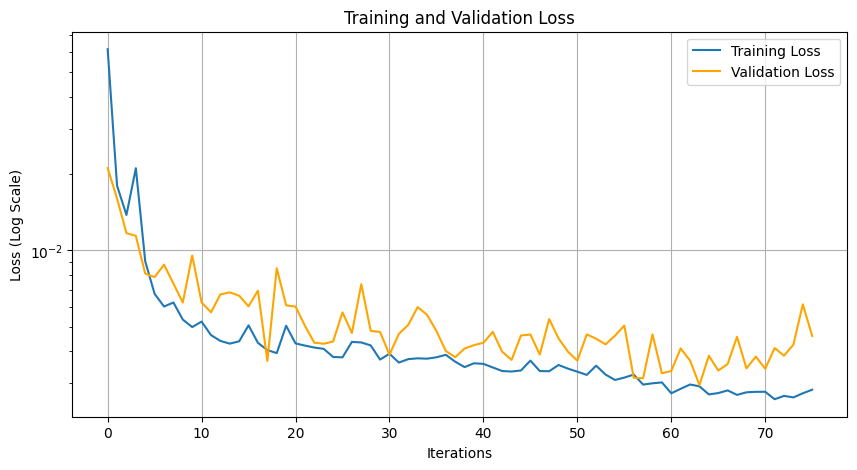

In [38]:
if conf.train_mode == "k-fold":
  ## Trainning
  train_start_time = time.time() # 记录时间
  model_train_KFold(num_epochs=50,
                    learning_rate=0.0001,
                    num_fold=10)

  ## Save and Record
  torch.save(model.state_dict(), "3d_cnn_model_v2.pth") # 再次保存模型
  train_end_time = time.time() # 记录时间
  trainning_time = train_end_time - train_start_time # 计算训练时间

  ## Print
  print("✅ 继续训练完成，已保存为 `3d_cnn_model_v2.pth`")
  print(f"🕛 训练耗时: {trainning_time:.2f} 秒")

  ## Plot: loss
  plot_loss(plot_val_loss=True)

## 4.2. OPTION: Simple 2-stage trainning

In [39]:
if conf.train_mode == "simple":
  ## Trainning: stage-1
  train_start_time = time.time() # 记录时间
  model_train_simple(num_epochs=2,learning_rate=0.0002) # 训练
  torch.save(model.state_dict(), "3d_cnn_model.pth") # save
  print("✅ 模型训练完成，已保存！")


  ## Trainning: stage-2
  model.load_state_dict(torch.load("3d_cnn_model.pth")) # load model
  model_train_simple(num_epochs=2,learning_rate=0.0001) # train

  ## Save and Record
  torch.save(model.state_dict(), "3d_cnn_model_v2.pth") # 再次保存模型
  train_end_time = time.time() # 记录时间
  trainning_time = train_end_time - train_start_time # 计算训练时间

  ## Print
  print("✅ 继续训练完成，已保存为 `3d_cnn_model_v2.pth`")
  print(f"🕛 训练耗时: {trainning_time:.3f} 秒")

  ## Plot: loss
  plot_loss()

Note:\
As TC added, 4$e^{-4}$ shows gradient disapper (loss:Nan)\
$\therefore$ 4$e^{-4}$ $\rightarrow$ 2$e^{-4}$\

When reducing the amount of predicting parameters, loss drops faster at the first step (0.007 -> 0.004)

**Note**

when loss = 0.000139, seems to have good prediction capability

# 5.Model Testing

In [40]:
# 加载模型
model = conf.model                        # Create an instance of your model
model.load_state_dict(torch.load('3d_cnn_model_v2.pth'))  # Load the saved state_dict
model.eval()                                              # Set the model to evaluation mode

# 用于存储预测值和真实值
predictions_scaled   = []
actual_values_scaled = []


# 用于存储总的损失
total_loss    = 0.0
criterion     = conf.criterion
test_loss_history    = []

# 推理
reasoning_start_time = time.time() # 记录时间
with torch.no_grad():
    for label, grid, items in tqdm(test_loader, desc=f"Evaluating..."): # Changed description
        label, grid, items = label.to(device), grid.to(device), items.to(device)
        grid    = grid.unsqueeze(1)               # 添加 channel 维度 (channels, depth, height, width) for 3D CNN
        output  = model(grid, items[:, 0])        # TODO: 确保 输入grid + temp_i, 前向传播
        loss    = criterion(output, items[:, 1:]) # TODO: 确保 输入 temp_i 以后的
        total_loss += loss.item()

        # Append predictions and actual values to the lists
        predictions_scaled.extend(output.cpu())         # Move predictions to CPU
        actual_values_scaled.extend(items[:, 1:].cpu()) # Move actual values to CPU

        # record
        test_loss_history.append(total_loss / len(test_loader))

reasoning_end_time = time.time() # 记录时间
reasoning_time = reasoning_end_time - reasoning_start_time # 计算推理时间
print(f"🕛 推理耗时: {reasoning_time:.3f} 秒")
print(f"Test Loss: {total_loss / len(test_loader):.6f}")

Evaluating...: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

🕛 推理耗时: 5.292 秒
Test Loss: 0.004631


# 6.Model Evaluation

**📌 8.1 绝对误差 (MAE - Mean Absolute Error)**
$$
\text{MAE} = \frac{1}{n} \sum |y_{true} - y_{pred}|
$$

- 衡量模型预测误差的平均绝对值。
- 与 MSE 相比，MAE 不会放大较大的误差，对异常值（outliers）更鲁棒。

In [41]:
MAE = mean_absolute_error(actual_values_scaled, predictions_scaled)
print(f"📉 MAE: {MAE:.4f}")

📉 MAE: 0.0406


**📌 8.2 均方误差(MSE - Mean Squared Error)**
$$
\text{MSE} = \frac{1}{n} \sum \left(y_{true} - y_{pred}\right)^2
$$

- 衡量模型预测误差的平方平均值，放大较大误差，对异常值敏感。


In [42]:
MSE = mean_squared_error(actual_values_scaled, predictions_scaled)
print(f"📉 MSE: {MSE:.4f}")

📉 MSE: 0.0047


**📌 8.3. 均方根误差(RMSE - Root Mean Squared Error)**
$$
RMSE = \sqrt{MSE}
$$

- RMSE = MSE 开平方，单位与原变量一致，更易解释。

In [43]:
RMSE = np.sqrt(MSE)
print(f"📉 RMSE: {RMSE:.4f}")

📉 RMSE: 0.0684


**📌 8.4 平均百分比误差(MAPE - Mean Absolute Percentage Error)**
$$
MAPE = \frac{1}{n} \sum \left| \frac{y_{true} - y_{pred}}{y_{true}} \right| x 100 \text{%}
$$

- 衡量预测误差相对于真实值的百分比，适用于不同尺度的数据。
- ⚠️ 适用于非负数据，否则可能会报错。


In [44]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(np.array(actual_values_scaled), np.array(predictions_scaled))
print(f"📉 MAPE: {MAPE:.2f}%")

📉 MAPE: inf%


<ipython-input-44-52ec4e328dbf>:2: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


**📌 8.5 解释方差得分(Explained Variance Score)**
$$
EVS = 1 - \frac{Var(y_{true}-y_{pred})}{Var(y_{true})}
$$

- 衡量模型对数据方差的解释能力，类似 R²，但不受数据缩放影响。

In [45]:
EVS = explained_variance_score(actual_values_scaled, predictions_scaled)
print(f"📊 Explained Variance Score: {EVS:.4f}")

📊 Explained Variance Score: 0.8825


**📌 8.6 平均对数误差(MSLE - Mean Squared Logarithmic Error)**
$$
\text{MSLE} = \frac{1}{n} \sum \left( \log(1 + y_{\text{true}}) - \log(1 + y_{\text{pred}}) \right)^2
$$

- 适用于预测值变化范围较大的情况（如预测收入、人口等）。
- 避免极端值影响，更关注相对误差。
- ⚠️ 适用于非负数据，否则可能会报错。


In [46]:
MSLE = mean_squared_log_error(actual_values_scaled, predictions_scaled)
print(f"📉 MSLE: {MSLE:.4f}")

📉 MSLE: 0.0025


**📌 8.7 皮尔逊相关系数（Pearson Correlation Coefficient）**
$$
\text{PCC} = \frac{\text{Cov}(y_{\text{true}}, y_{\text{pred}})}{\sigma_{y_{\text{true}}} \cdot \sigma_{y_{\text{pred}}}}
$$

- 衡量预测值和真实值之间的线性相关性，范围在 \([-1,1]\) 之间：
  - **+1** 表示完全正相关
  - **0** 表示无相关性
  - **-1** 表示完全负相关


In [47]:
PCC, _ = scipy.stats.pearsonr(np.array(actual_values_scaled).flatten(), np.array(predictions_scaled).flatten())
print(f"📈 Pearson Correlation Coefficient: {PCC:.4f}")

📈 Pearson Correlation Coefficient: 0.9692


**📌 8.7 方误差($R^{2}$ )**
**R² 公式**

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

其中：

- $SS$ = Sum of Squares
- $SS_{res} = \sum (y_{\text{true}} - y_{\text{pred}})^2$ —— 残差平方和
- $SS_{tot} = \sum (y_{\text{true}} - \bar{y}_{\text{true}})^2$ —— 总平方和
- $\bar{y}_{\text{true}}$ 是真实值的均值。

**R² 的解释**

- **\( R^2 = 1.0 \)**：模型完美拟合数据。
- **\( 0 < R^2 < 1 \)**：模型有一定的解释能力，但仍有误差。
- **\( R^2 $\leq$ 0 \)**：模型甚至比简单的均值预测还差。



In [48]:
# 计算 R² Score
R2 = r2_score(actual_values_scaled, predictions_scaled)
print(f"📊 R² Score: {R2:.4f}")

📊 R² Score: 0.8710


**📌 8.8 训练与推理耗时 (Time consumed)**

In [49]:
# 输出评估结果
print(f"🕛 训练耗时：{trainning_time:3f} 秒")
print(f"🕛 推理耗时: {reasoning_time:.3f} 秒")

🕛 训练耗时：8166.284114 秒
🕛 推理耗时: 5.292 秒


📌 8.9 对比总结

| 指标  | 作用 | 适用场景 |
|------|------|--------|
| **MSE**  | 误差平方平均，放大异常值 | 关注大误差 |
| **RMSE** | MSE 开平方，与真实值单位一致 | 直观解释误差 |
| **MAE**  | 误差绝对值平均 | 抗异常值能力强 |
| **MAPE** | 误差的相对百分比 | 适用于不同尺度数据 |
| **R²**   | 解释模型的拟合程度 | 衡量整体效果 |
| **EVS**  | 解释数据方差的能力 | 类似 R²，但不受缩放影响 |
| **MSLE** | 计算对数误差 | 适用于指数增长问题 |
| **PCC**  | 相关性分析 | 判断预测值与真实值的线性相关性 |

---

📌 8.10 结论

✅ **如果你关注误差的实际大小**：使用 **MSE / RMSE / MAE**  
✅ **如果你需要标准化的模型评价**：使用 **R² / EVS**  
✅ **如果数据具有不同尺度**：使用 **MAPE**  
✅ **如果数据分布有长尾效应（指数增长）**：使用 **MSLE**  
✅ **如果你想分析预测值和真实值的相关性**：使用 **PCC**  



# 7.Vissualization

In [50]:
# check 归一化参数
def scaler_checker(idx,scaler=joblib.load("scaler.pkl")):
  print(f'item:\t{conf.DB_items[idx]}\n'
      f'min:\t{scaler.data_min_[idx]:.2f} \t\t# 训练数据的最小值 (每列) \n'
      f'max:\t{scaler.data_max_[idx]:.2f} \t\t# 训练数据的最大值 (每列) \n'
      f'range:\t{scaler.data_range_[idx]:.2f} \t\t# max - min (每列) \n'
      f'offset:\t{scaler.min_[idx]:.2f} \t\t# 归一化偏移量，计算公式：`-min * scaler`\n'
      f'scaler:\t{scaler.scale_[idx]:.2f} \t\t# 归一化比例因子，计算公式：`1 / data_range_`\n')

In [51]:
for idx in range(1,len(conf.DB_items)):
  scaler_checker(idx)

item:	len
(A)
min:	2.00 		# 训练数据的最小值 (每列) 
max:	20.00 		# 训练数据的最大值 (每列) 
range:	18.00 		# max - min (每列) 
offset:	-0.11 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	0.06 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	density
(g/cm^3)
min:	0.02 		# 训练数据的最小值 (每列) 
max:	0.88 		# 训练数据的最大值 (每列) 
range:	0.86 		# max - min (每列) 
offset:	-0.02 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	1.16 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	pore_radius
(A)
min:	6.39 		# 训练数据的最小值 (每列) 
max:	163.42 		# 训练数据的最大值 (每列) 
range:	157.04 		# max - min (每列) 
offset:	-0.04 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	0.01 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	porosity
(unitless)
min:	0.81 		# 训练数据的最小值 (每列) 
max:	1.00 		# 训练数据的最大值 (每列) 
range:	0.19 		# max - min (每列) 
offset:	-4.36 		# 归一化偏移量，计算公式：`-min * scaler`
scaler:	5.38 		# 归一化比例因子，计算公式：`1 / data_range_`

item:	specific_surface_area
(m^2/g)
min:	1257.93 		# 训练数据的最小值 (每列) 
max:	2466.14 		# 训练数据的最大值 (每列) 
range:	1208.21 		# max - min (每列) 
offset:	-1.04 		# 归一化偏移量，计算公式：`-mi

归一化公式：
$$
X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

反归一化：
$$
X_{\text{original}} = X_{\text{scaled}} \times (X_{\max} - X_{\min}) + X_{\min}
$$

Range:
$$
X_{\text{range}} = X_{\max} - X_{\min}
$$

Offset:
$$
X_{\text{offset}} = - X_{\min} \times X_{\text{scaler}}
$$

Scaler:
$$
X_{\text{scaler}} = \frac{1}{X_{\text{range}}}
$$

In [52]:
# 转换为 numpy 数组
predictions_scaled   = np.array(predictions_scaled).copy()
actual_values_scaled = np.array(actual_values_scaled).copy()

# 反归一化
reverse_nromalization = True
if reverse_nromalization:
  scaler          = joblib.load("scaler.pkl")
  scaler.min_     = scaler.min_[1:] # 只选择 scaler 的前 2 维
  scaler.scale_   = scaler.scale_[1:]
  predictions     = scaler.inverse_transform(predictions_scaled)
  actual_values   = scaler.inverse_transform(actual_values_scaled)
# 不做反归一化
else:
  predictions     = predictions_scaled
  actual_values   = actual_values_scaled

In [53]:
# 定义绘图参数
def plot_prediction_results(actual_values, predictions, target_idx):
    """
    绘制预测结果分析图（预测 vs 真实值、误差分布、误差 vs 真实值）

    参数：
    - actual_values: 真实值的 NumPy 数组 (N, 2)
    - predictions: 预测值的 NumPy 数组 (N, 2)
    - target_idx: 目标变量索引（0 或 1）
    - target_name: 目标变量的名称 (str)
    """
    target_name = conf.DB_items[target_idx + 1].replace('\n', ' ')  # skip temp
    errors = predictions[:, target_idx] - actual_values[:, target_idx]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ 预测值 vs 真实值
    axes[0].scatter(actual_values[:, target_idx], predictions[:, target_idx], c='blue', label='Predictions')
    axes[0].plot([min(actual_values[:, target_idx]), max(actual_values[:, target_idx])],
                 [min(actual_values[:, target_idx]), max(actual_values[:, target_idx])], 'r--', label='Ideal fit')
    axes[0].set_xlabel(f'Actual Values ({target_name})')
    axes[0].set_ylabel(f'Predicted Values ({target_name})')
    axes[0].set_title(f'Predicted vs Actual Values ({target_name})')
    axes[0].legend()
    axes[0].grid(True)

    # 2️⃣ 误差分布直方图
    axes[1].hist(errors, bins=25, color='purple', edgecolor='black')
    axes[1].set_xlabel(f'Prediction Error ({target_name})')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Distribution of Prediction Errors ({target_name})')
    axes[1].grid(True)

    # 3️⃣ 误差 vs 真实值
    axes[2].scatter(actual_values[:, target_idx], errors, c='green')
    axes[2].axhline(y=0, color='r', linestyle='--')
    axes[2].set_xlabel(f'Actual Values ({target_name})')
    axes[2].set_ylabel(f'Prediction Error ({target_name})')
    axes[2].set_title(f'Prediction Error vs Actual Values ({target_name})')
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(f'Prediction_Results.png')
    plt.show()

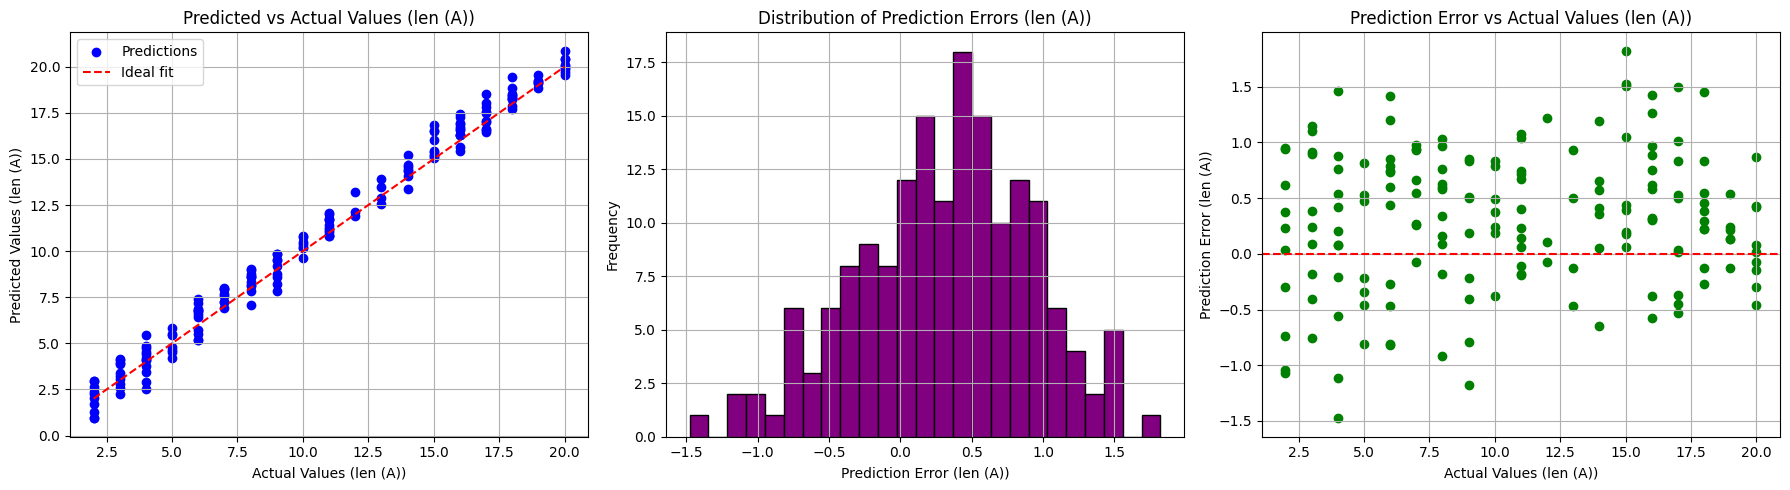

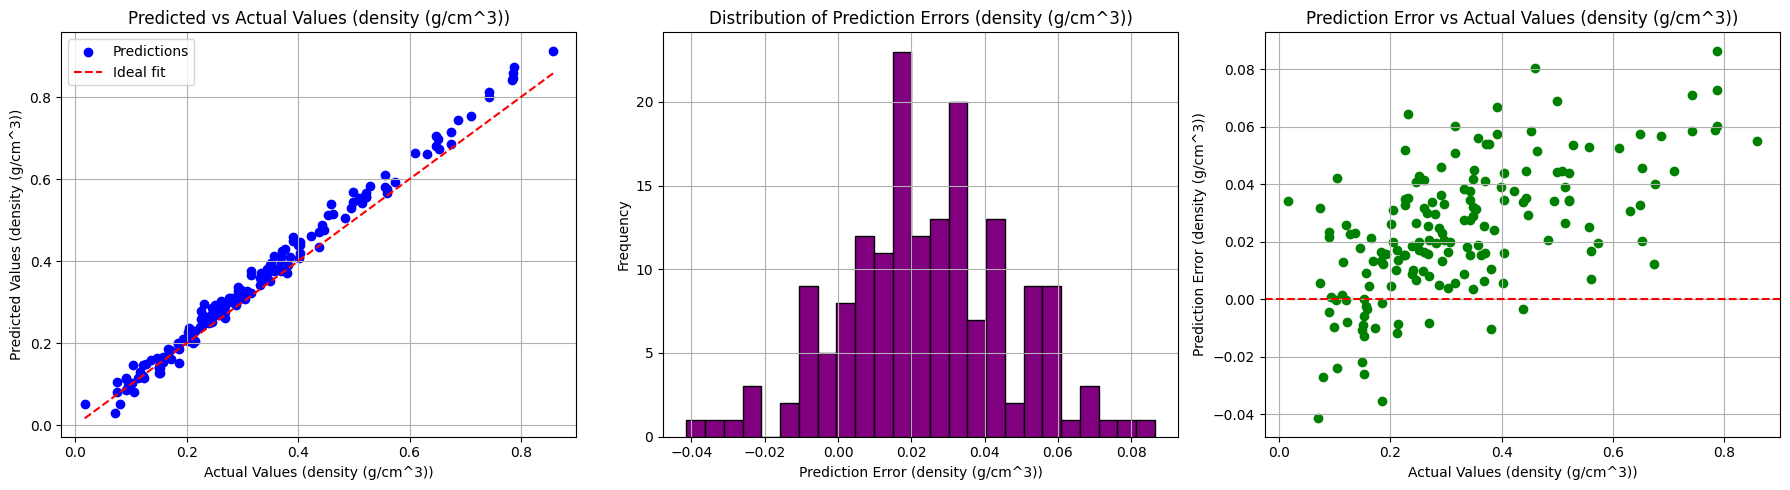

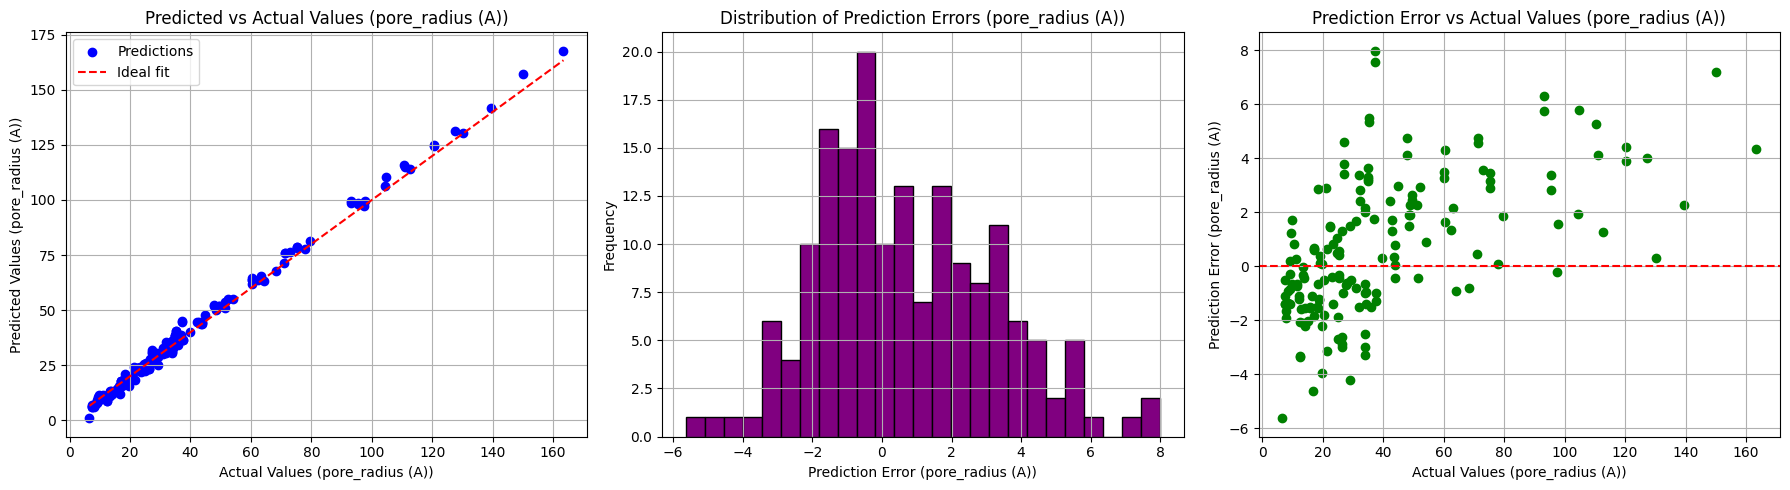

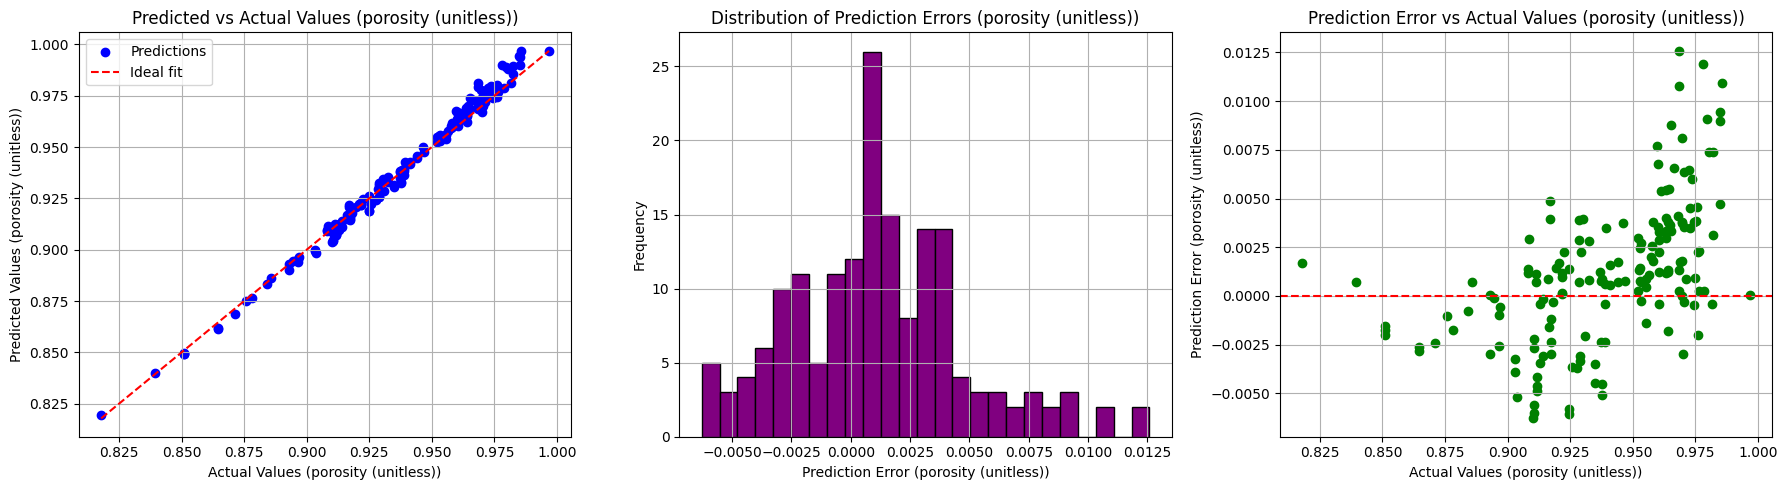

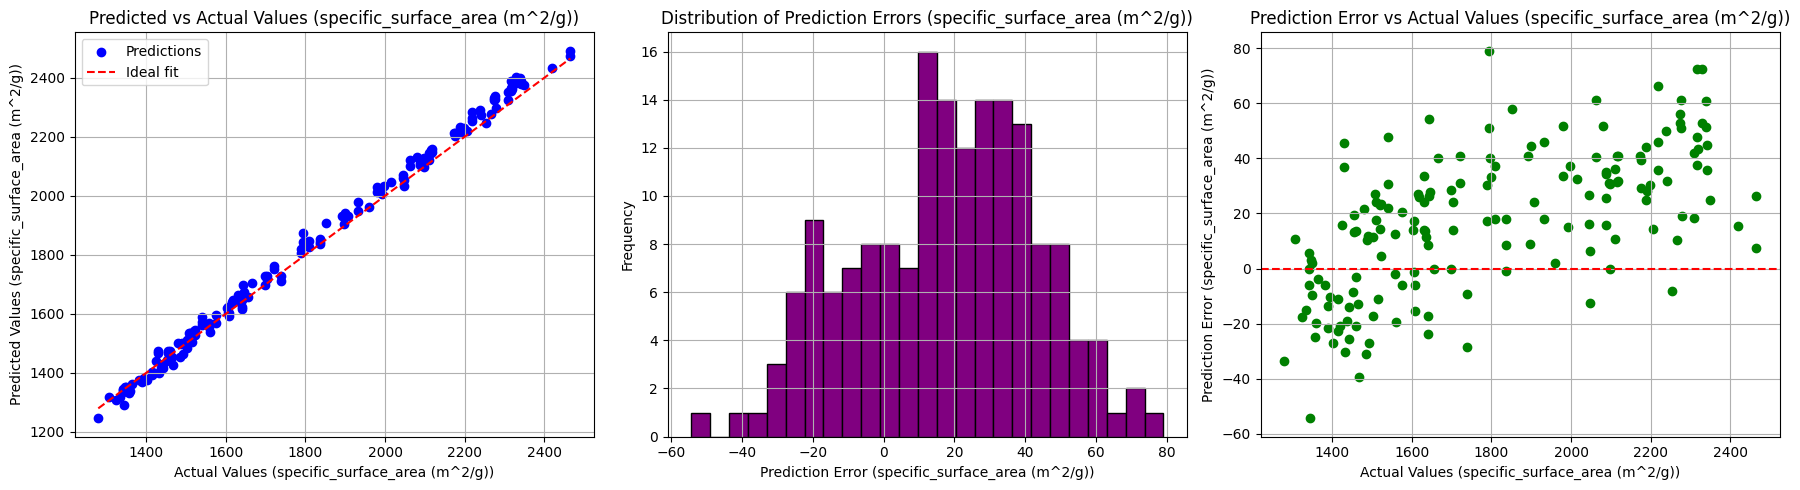

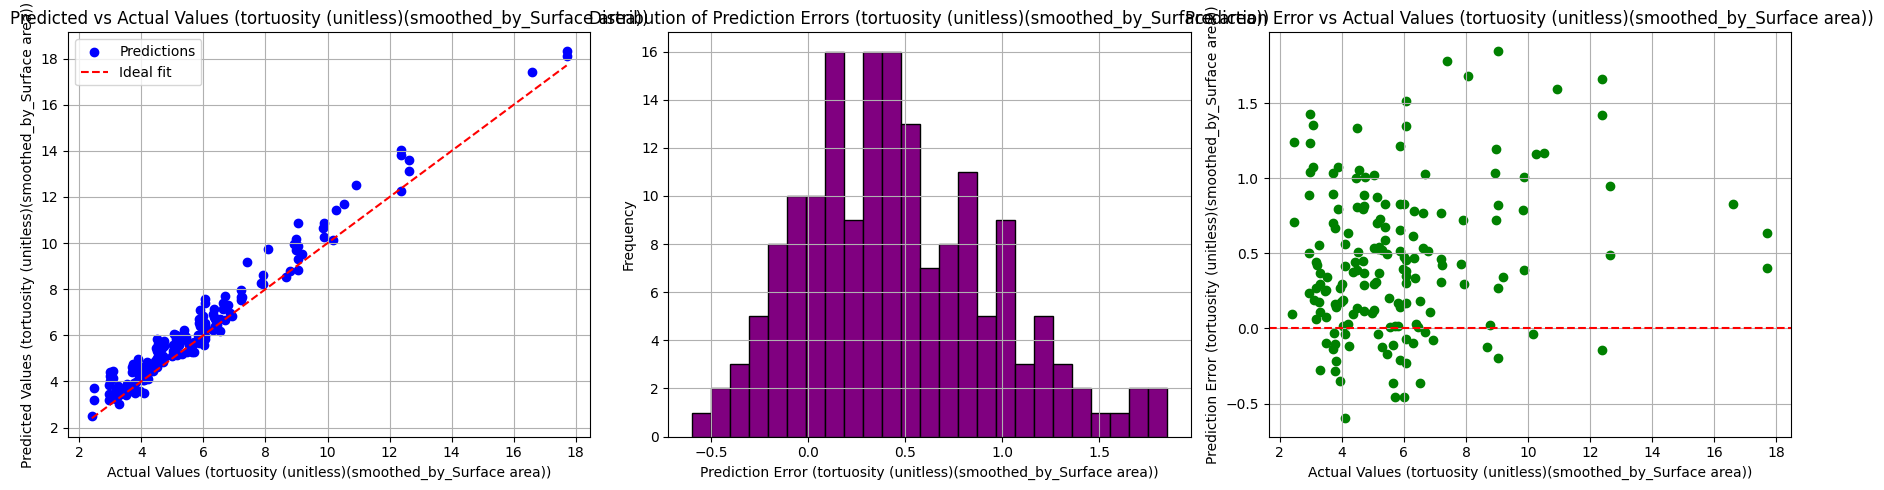

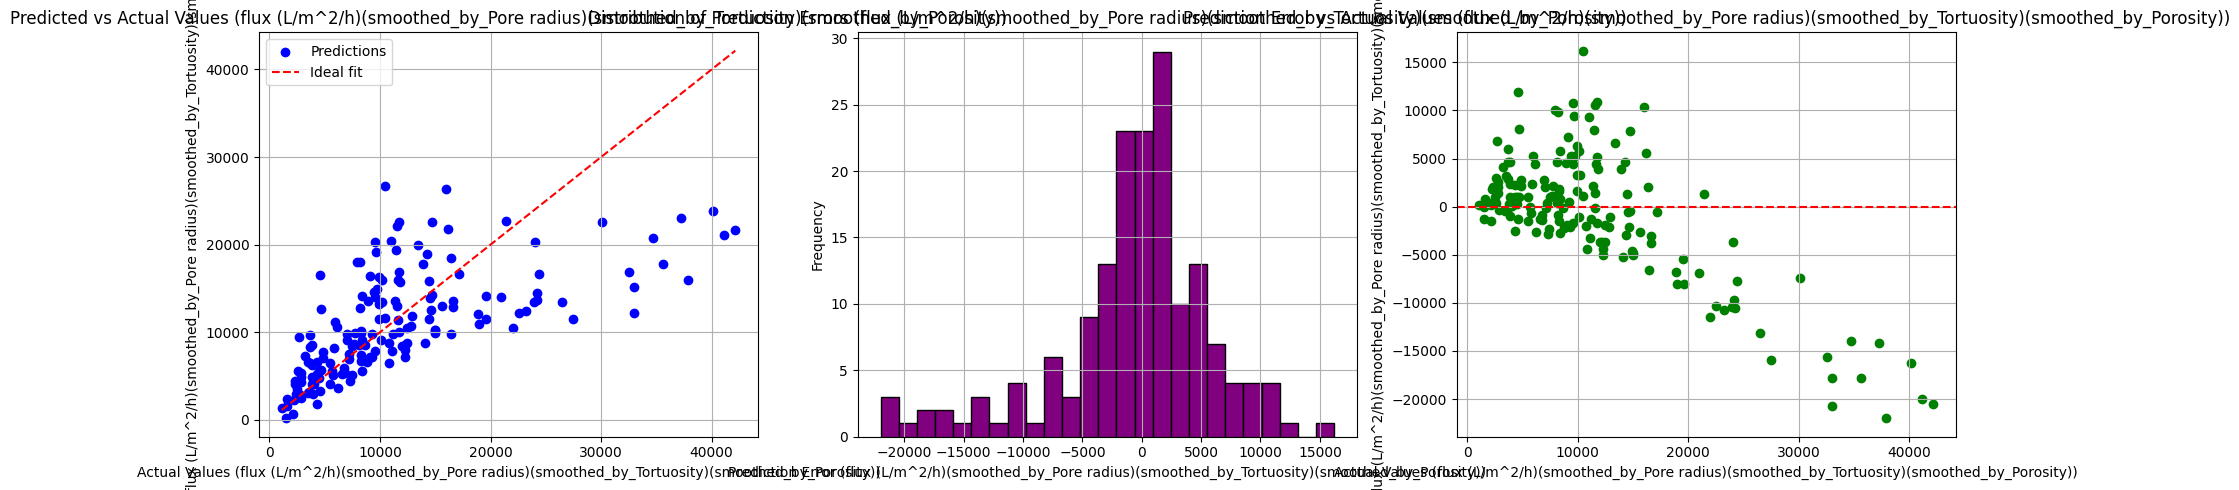

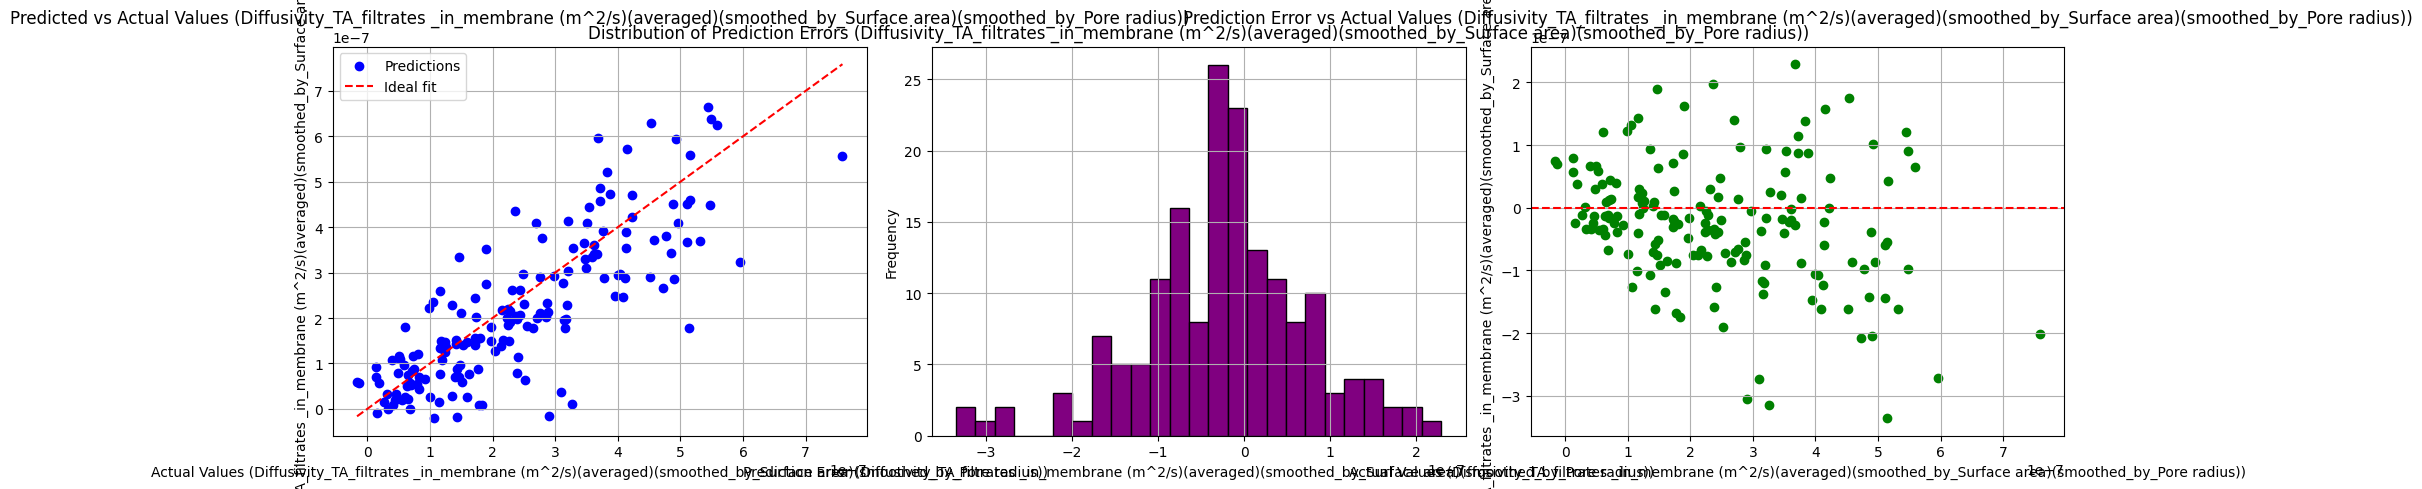

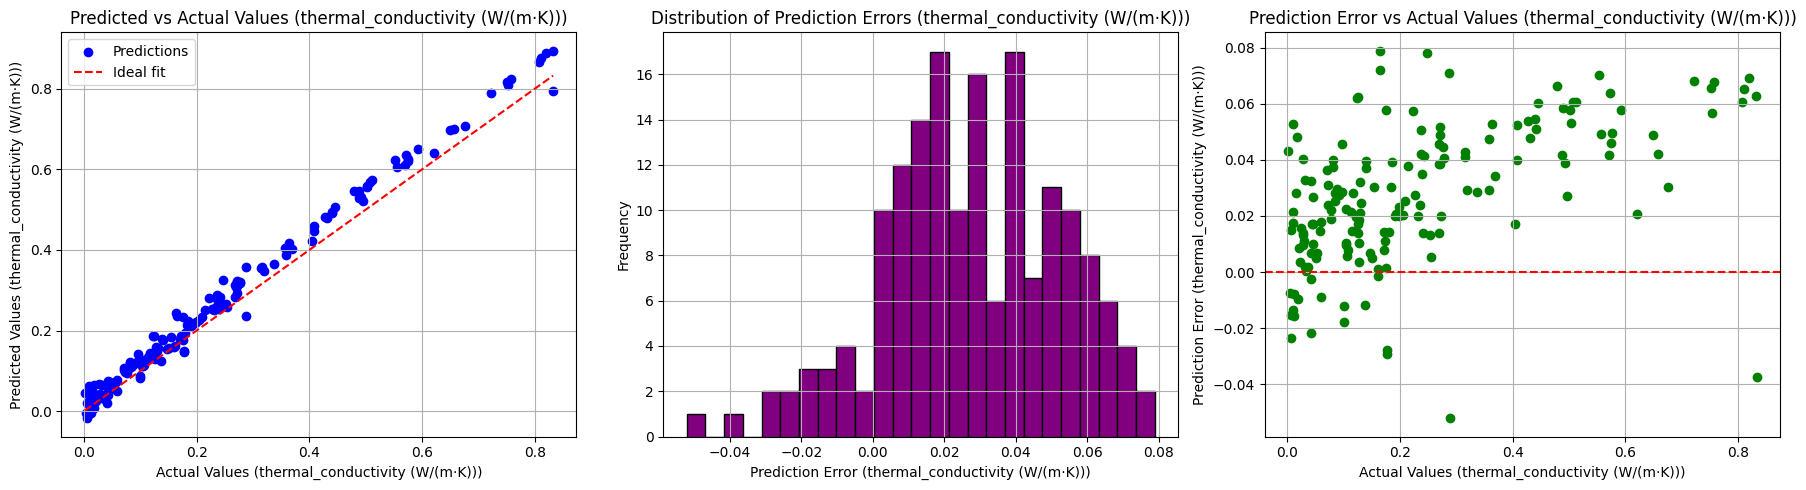

In [54]:
# 调用函数绘制目标值 1 (Target 1)
for idx in range(0,predictions.shape[1]):
  plot_prediction_results(actual_values, predictions, target_idx=idx)

# 8.Save

In [55]:
## Save file ##

# 获取当前时间戳（格式：YYYYMMDD_HHMMSS）
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 获取模型类型
model_type = type(model).__name__  # 提取模型类名，如 "Improved3DCNN"

# 构造文件名
file_name = f"model_results_{model_type}_{timestamp}.pkl"
file_path = f"/content/{file_name}"  # Colab 默认存储路径

# 创建保存字典
results_dict = {
    "predictions": predictions,
    "actual_values": actual_values,
    "scaler": scaler,
    "train_loss_history": train_loss_history,
    "test_loss_history": test_loss_history,
    "trainning_time": trainning_time,
    "reasoning_time": reasoning_time,
    "R2": R2,
    "MSE": MSE,
    "RMSE": RMSE,
    "MAE": MAE,
    "EVS": EVS,
    "MSLE": MSLE,
    "PCC": PCC
}

# 记录开始时间
save_start_time = time.time()

# 保存到文件
with open(file_path, "wb") as f:
    pickle.dump(results_dict, f)
    pickle.dump(model, f)

# 记录结束时间
save_end_time = time.time()
save_time = save_end_time - save_start_time

# 获取文件大小
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)

# 打印文件信息
print(f"✅ 结果已保存到:  {file_path}")
print(f"💾 文件大小:     {file_size_mb:.3f} MB")
print(f"⏳ 保存耗时       {save_time:.4f} 秒")
print(f"📂 下载文件名:    {file_name}")

✅ 结果已保存到:  /content/model_results_Improved3DCNN_20250501_054029.pkl
💾 文件大小:     133.933 MB
⏳ 保存耗时       0.3190 秒
📂 下载文件名:    model_results_Improved3DCNN_20250501_054029.pkl


In [56]:
## Post Check ##
if conf.dev_mode:
  # 1️⃣ 读取保存的文件
  if os.path.exists(file_path):
      with open(file_path, "rb") as f:
          loaded_results = pickle.load(f)
      print("✅ 成功加载 model_results.pkl")
  else:
      raise FileNotFoundError(f"❌ 未找到文件: {file_path}")

  # 2️⃣ 读取变量
  expected_keys = [
      "predictions",
      "actual_values",
      "scaler",
      "train_loss_history",
      "test_loss_history",
      "test_loss_history",
      "trainning_time",
      "reasoning_time",
      "R2",
      "MSE",
      "RMSE",
      "MAE",
      "EVS",
      "MSLE",
      "PCC"
  ]

  # 检查是否所有变量都正确存储
  missing_keys = [key for key in expected_keys if key not in loaded_results]
  if missing_keys:
      print(f"⚠️ 缺少变量: {missing_keys}")
  else:
      print("✅ 所有变量均已正确存储！")

  # 3️⃣ 测试变量的长度和内容
  print("\n📊 变量检查报告")

  for key, value in loaded_results.items():
      if isinstance(value, (list, tuple, set)):
          print(f"🔹 {key}: 长度 {len(value)}")
      elif isinstance(value, dict):
          print(f"🔹 {key}: 包含 {len(value.keys())} 个键")
      elif isinstance(value, (int, float, str)):
          print(f"🔹 {key}: 值 {value}")
      else:
          print(f"🔹 {key}: 类型 {type(value)}")

  print("\n✅ 核验完成！")

In [57]:
# 下载文件（仅限 Google Colab）
from google.colab import files  # 仅在 Google Colab 运行
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# 终止会话
from google.colab import runtime
runtime.unassign()